# 크롤링 - 네이버 검색

### 0. 검색어 셋팅 등
- 스크롤 횟수 설정
- 파일 저장 경로설정

In [1]:
keyword = '네일추천 맞춤네일 셀프네일 네일디자인 네일후기 손톱색상'

# 검색어 입력 안될경우 오픈된 상태에서 수동 입력

search_keyword = keyword

# 검색일자
start_date='20240101'
end_date='20251113'

# 스크롤 횟수
scroll_times = 5 
    
file_path = './'
file_name = 'craw-' + keyword + '.csv'

## 1. 페이지 로드
- 페이지 로드
- 페이지 드레그

In [2]:
### 1. 페이지 로드
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd

from urllib.parse import quote_plus

def encode_keyword(search_keyword: str) -> str:
    return quote_plus(search_keyword)

driver = webdriver.Chrome()
#url = 'https://search.naver.com/search.naver?where=news&ie=utf8&sm=nws_hty&query='+search_keyword


url = f'https://search.naver.com/search.naver?ssc=tab.blog.all&query={search_keyword}&sm=tab_opt&nso=so%3Ar%2Cp%3Afrom{start_date}to{end_date}'

driver.get(url)

In [3]:
### 페이지 드레그

from time import sleep
import random

xp = '/html'
review_box = driver.find_element(By.XPATH, xp) # 드래그가 있는 요소 가져오기

#for i in range(scroll_times):
for i in range(30):
    driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', review_box)
    sleep(random.randint(2, 3)) # 2~3초 쉬었다가 반복

## 2. 함수 

### 2-1. 일자 정리
- n {분/시간/일/주} 전 -> 일자 로 반환
- 탑 헤드라인 경우, 일자 보다 앞서는 객체인 문제 수정

In [4]:
### 2-1. 일자 정리

import re
from datetime import datetime, timedelta, timezone

KST = timezone(timedelta(hours=9))

_abs = re.compile(r"^\s*(\d{4})\.(\d{1,2})\.(\d{1,2})\.?\s*$")
_m  = re.compile(r"(\d+)\s*분\s*전")
_h  = re.compile(r"(\d+)\s*시간\s*전")
_d  = re.compile(r"(\d+)\s*일\s*전")
_w  = re.compile(r"(\d+)\s*주\s*전")
_not_date_tail = re.compile(r"(?:단|TOP),\s*$")        # 예: "A34면 1단," , "A30면 TOP,"

def _ymd(dt: datetime) -> str:
    # Python/Excel 공통 인식 포맷: YYYY-MM-DD
    return f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

def normalize_news_date(texts, now: datetime | None = None) -> str | None:
    # 변환 실패 대비: 원본 첫 값 보관
    original_first = texts if isinstance(texts, str) else (texts[0] if texts else None)

    if isinstance(texts, str):
        texts = [texts]
    now = now or datetime.now(KST)

    for t in texts:
        if not t:
            continue
        s = t.strip()

        # 지면/면·단, TOP 꼬리면 스킵
        if _not_date_tail.search(s):
            continue

        # 절대형
        m = _abs.match(s)
        if m:
            y, mo, d = map(int, m.groups())
            return f"{y:04d}-{mo:02d}-{d:02d}"

        # 상대형
        if (mm := _h.search(s)): # 분
            return _ymd(now - timedelta(minutes=int(mm.group(1))))
        if (mh := _h.search(s)): # 시간
            return _ymd(now - timedelta(hours=int(mh.group(1))))
        if (md := _d.search(s)): # 일
            return _ymd(now - timedelta(days=int(md.group(1))))
        if (mw := _w.search(s)): # 주
            return _ymd(now - timedelta(weeks=int(mw.group(1))))

    # 날짜형 변환이 안되면 첫 번째 값 반환
    return original_first

### 2-2. 컨텐츠 담기 (한 박스 기준)

In [5]:
### 2-2. 컨텐츠 담기 (한 뉴스 박스 기준)

import os

from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

### 2-3. 컨텐츠 담기 (한 뉴스 박스 기준) 해시 지양, 구조 기반
def get_content(review):
    condic = {}
    title_css = 'span.sds-comps-text.sds-comps-text-ellipsis.sds-comps-text-ellipsis-1.sds-comps-text-type-headline1.sds-comps-text-weight-sm'
    text_css = 'div.sds-comps-vertical-layout.sds-comps-full-layout.yWOW1GibW1n0WYR3RQRc'
    viewer_css = 'div.sds-comps-horizontal-layout.sds-comps-inline-layout.sds-comps-profile-info-title'
    date_css = 'span.sds-comps-text.sds-comps-text-type-body2.sds-comps-text-weight-sm.sds-comps-profile-info-subtext'
    condic['writer'] = review.find_element(By.CSS_SELECTOR, viewer_css).get_attribute('innerText').strip()
    condic['title'] = review.find_element(By.CSS_SELECTOR, title_css).get_attribute('innerText').strip()
    condic['text'] = review.find_element(By.CSS_SELECTOR, text_css).get_attribute('innerText').strip()
    condic['date'] = normalize_news_date(review.find_element(By.CSS_SELECTOR, date_css).get_attribute('innerText').strip())
    return condic

## 3. 크롤링
- 박스 선택
- 박스 별 자료 담기

In [6]:
# 박스 선택
forms = driver.find_elements(
    By.CSS_SELECTOR,
    'div.sds-comps-vertical-layout.sds-comps-full-layout.KuzouLxTqWJ5UVpERiYP'
)
print('박스 수', ':', len(forms))

# 박스 별 자료 담기
result = []
for form in forms:
    try:
        dic = get_content(form)
        # 필수 2필드 이상 있을 때만 추가 (노이즈 방지)
        if sum(v is not None and str(v).strip() != "" for v in
               (dic["writer"],dic["date"], dic["title"], dic["text"])) >= 4:
            result.append(dic)
    except NoSuchElementException:
        # 구조가 다른 카드 무시하고 계속
        # print('NoSuchElementException')
        continue

df = pd.DataFrame(result)
df.head()

박스 수 : 930


,writer,title,text,date
0,SWEET HOME,짧은손톱 셀프네일러 일대기 (3개월차 리뷰+셀프네일재료추천),오늘은 3개월 차 셀프네일러 후기를 남겨보려고 합니다 셀프네일 후기를 찾아봐도 대부...,2025-11-13
1,대대공방,손톱 길이별 네일 디자인 추천 & 셀프 네일 필수템 공개!,"손톱 길이별 네일 디자인 추천 & 셀프 네일 필수템 공개! 손톱 길이, 나만의 스타...",2025-10-24
2,정원여신,광명네일추천 디자인 예쁘게 잘하는곳 손톱 이쁜 M네일 후기,광명네일추천 디자인 예쁘게 잘하는곳 손톱 이쁜 M네일 후기 안녕하세요? 뷰티 꿀 팁...,2025-08-13
3,데이영로그,압구정 네일샵 아인네일 본식 웨딩네일 디자인 시기 작은손톱 추천 후기,추천 ] 아인네일 작은 손톱 웨딩 네일 | 글 / 사진 © 데이영 안녕하세요 데이영...,2025-10-31
4,이상,손톱영양제 추천 반디 다이아포스듀오 셀프 네일큐어 큐티클관리법,손톱영양제 추천 반디 다이아포스듀오 셀프 네일큐어 큐티클관리법 긴 명절의 후유증이 ...,2025-10-17


## 4. 후처리
- 파일 생성
- 데이터 점검 (날짜 포맷 변환 실패)

In [7]:
### 파일 생성 - 생략
# os.makedirs(file_path, exist_ok=True)
# df.to_csv(file_path + file_name, index=False)

In [8]:
### 데이터 점검 (날짜 포맷 변환 실패)

df['date'] = pd.to_datetime(df['date'], errors='coerce')

print('날짜 포맷 변환 실패', ':', sum(df['date'].isna()))

날짜 포맷 변환 실패 : 0


# 키워드 분석

In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트
font_path = 'basic_data/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'

FileNotFoundError: [Errno 2] No such file or directory: 'NanumGothic.ttf'

## 텍스트 전처리 
- 토큰화
- 클렌징
- 불용어 제거
- 형태소 분석

In [10]:
import re

from mecab import MeCab
mecab = MeCab()

from kiwipiepy import Kiwi


# 원하는 품사 태그 목록 설정
use_tags = ['NNP', 'NNG', 'NP', 'IC', 'MAG']

# 불용어 목록
stopwords = ['이번', '가능', '작년', '지난해', '이', '다', '및', '특히']

# ROW 제외 키워드
exclude_row_words = ['중국', '전세계', '전 세계', '아프리카', '미국', '주요국' #지역 키워드 대응
                     , '호우' # 강수 (비) 에 대한 언급 대응 ex. 비만 오면.. 
                    ]

# 이름 용어 등 명사 등록
kiwi = Kiwi()
for w in []: #'위고비'
    try:
        kiwi.add_user_word(w, "NNP")
    except ValueError:
        pass

def shortword_cleaning(text): ## 축약어 등 변환
    rep = {
        '카톡': '카카오톡', # 예시
        '톡서랍': '카카오톡 서랍'
    }
    for k, v in rep.items():
        text = text.replace(k, v)
    return text
#

# 토큰화 함수 정의
def cleaning(text):
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    text = re.sub(r'[\n\t]', ' ', text)  # 줄바꿈, 탭 제거
    text = re.sub(r'\s+', ' ', text)  # 연속된 공백 제거
    text = text.strip() # 문장 양끝 공백 제거

    ### 품사 태그와 함께 토큰화 ### (MeCab/kiwipiepy)
    #kwords = mecab.pos(text)

    kwords = kiwi.tokenize(text)

    # 원하는 품사만 필터링
    kwords = [w[0]for w in kwords if w[1] in use_tags]
    # 불용어 제거 추가
    kwords = [word for word in kwords if word not in stopwords]
    clean = ' '.join(kwords)

    # # 한글자 제거
    # text = ' '.join([word for word in text.split() if len(word) > 1])

    return clean

# 클렌징 함수 적용
df['clean'] = (
    df['title'].fillna('') + ' ' +
    df['text'].fillna('')
).apply(shortword_cleaning).apply(cleaning)

# 정규식 OR 조건으로 필터링
pattern = '|'.join(exclude_row_words)

# 해당 단어가 들어간 행을 제외
df = df[~df['clean'].str.contains(pattern, case=False, na=False)]

print(len(df))
df.head()

925


,writer,title,text,date,clean
0,SWEET HOME,짧은손톱 셀프네일러 일대기 (3개월차 리뷰+셀프네일재료추천),오늘은 3개월 차 셀프네일러 후기를 남겨보려고 합니다 셀프네일 후기를 찾아봐도 대부...,2025-11-13,손톱 셀프네일러 일대기 리뷰 셀프 네일 재료 추천 오늘 셀프네일러 후기 셀프 네일 ...
1,대대공방,손톱 길이별 네일 디자인 추천 & 셀프 네일 필수템 공개!,"손톱 길이별 네일 디자인 추천 & 셀프 네일 필수템 공개! 손톱 길이, 나만의 스타...",2025-10-30,손톱 길 이별 네일 디자인 추천 셀프 네일 필수템 공개 손톱 길 이별 네일 디자인 ...
2,정원여신,광명네일추천 디자인 예쁘게 잘하는곳 손톱 이쁜 M네일 후기,광명네일추천 디자인 예쁘게 잘하는곳 손톱 이쁜 M네일 후기 안녕하세요? 뷰티 꿀 팁...,2025-08-13,광명 네일 추천 디자인 잘 곳 손톱 네일 후기 광명 네일 추천 디자인 잘 곳 손톱 ...
3,데이영로그,압구정 네일샵 아인네일 본식 웨딩네일 디자인 시기 작은손톱 추천 후기,추천 ] 아인네일 작은 손톱 웨딩 네일 | 글 / 사진 © 데이영 안녕하세요 데이영...,2025-10-30,압구정 네일 샵 아이 너 일 식 웨딩 네일 디자인 시기 손톱 추천 후기 추천 아인 ...
4,이상,손톱영양제 추천 반디 다이아포스듀오 셀프 네일큐어 큐티클관리법,손톱영양제 추천 반디 다이아포스듀오 셀프 네일큐어 큐티클관리법 긴 명절의 후유증이 ...,2025-10-16,손톱 영양제 추천 반디 다이아포스듀오 셀프 네일큐어 큐티클 관리법 손톱 영양제 추천...


## 빈도 & TF-IDF 그래프

1. 빈도그래프 그리기 빈도그래프를 그리기 위해 먼저 sklearn의 CountVectorizer를 이용하여 빈도 벡터를 만들고
   numpy의 sum()함수로 총 빈도값을 구합니다.
    이후 matplotlib를 활용하여 수평 막대그래프를 그려줍니다.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cvec = CountVectorizer(max_df=0.9, min_df=20, analyzer = 'word',
                       token_pattern = r'(?u)\b\w+\b' # 1글자 단어도 포함
                      )
X = cvec.fit_transform(df['clean'])
x = X.toarray()
print(x.shape)

# 토큰 목록을 배열로 가져옴
names = cvec.get_feature_names_out()
print(names)

# 각 토큰의 빈도 총합
xsum = np.sum(x, axis=0)
xsum

# 빈도 총합으로 정렬(순서)
rank_ind = np.argsort(xsum)
rank_ind

# top 키워드 추출
most_n = []
most_v = []
for ind in rank_ind[-50:]:
    most_n.append(names[ind]) # 토큰과 개수를 순서별로 저장
    most_v.append(xsum[ind])
print(most_n)
print(most_v)

(925, 262)
['가격' '가득' '가성비' '가을' '가장' '감각' '감성' '개성' '걱정' '건강' '겨울' '결정' '경험' '계속'
 '계절' '고객' '고급' '고려' '고민' '곳' '공간' '과정' '관리' '교정' '그냥' '그라데이션' '근처' '글'
 '글리터' '기본' '기분' '기존' '길' '길이' '깔끔' '꼭' '꼼꼼' '꼼꼼히' '꾸준히' '꿀' '끝' '나' '나트랑'
 '날' '내부' '너' '너무' '넘' '네이버' '눈' '느낌' '다낭' '다시' '다양' '다음' '단순히' '달' '더'
 '더욱' '덕분' '데일리' '도구' '도전' '돈' '동안' '디자인' '디테일' '딱' '때' '또' '라인' '리뷰'
 '마무리' '마음' '만족' '만족도' '많이' '말' '맘' '맛집' '맞춤' '매일' '매장' '먼저' '모두' '모습'
 '모양' '못' '무드' '무엇' '뭐' '미리' '바로' '발' '발톱' '방문' '방법' '버건디' '베이스' '변경' '부담'
 '부분' '부산' '분위기' '뷰티' '빛' '사랑' '사실' '사용' '사장' '사진' '살짝' '상담' '상태' '색' '색감'
 '색상' '샘플' '생각' '샵' '서비스' '선생' '선택' '세련' '센스' '셀프' '소개' '속눈썹' '손' '손가락'
 '손끝' '손상' '손톱' '수원' '쉐입' '스타일' '스톤' '스티커' '시간' '시럽' '시술' '시작' '시즌' '신상'
 '실력' '실버' '심플' '아이' '아주' '아트' '안' '엄청' '없이' '여기' '여름' '여행' '역시' '연장'
 '영양제' '영업시간' '예약' '오늘' '오래' '완벽' '완성' '완전' '왜' '요즘' '원' '원장' '웨딩' '위'
 '위생' '위치' '유명' '유지' '유행' '이거' '이달' '이벤트' '이상' '이용' '이유' '이제' '인' '인기'
 '인스타그램' '일' '자리' '자석' '자연' '자주' '자체' '잘' '저' '전' 

In [12]:
# top 키워드 추출
most_n = []
most_v = []
for ind in rank_ind[-20:]:
    most_n.append(names[ind]) # 토큰과 개수를 순서별로 저장
    most_v.append(xsum[ind])
print(most_n)
print(most_v)

['너무', '자석', '시술', '나', '손', '케어', '잘', '색상', '가을', '컬러', '셀프', '저', '일', '젤', '샵', '후기', '아트', '추천', '디자인', '손톱']
[np.int64(226), np.int64(229), np.int64(231), np.int64(251), np.int64(254), np.int64(289), np.int64(301), np.int64(304), np.int64(329), np.int64(419), np.int64(461), np.int64(476), np.int64(696), np.int64(755), np.int64(805), np.int64(882), np.int64(903), np.int64(1140), np.int64(1259), np.int64(1471)]


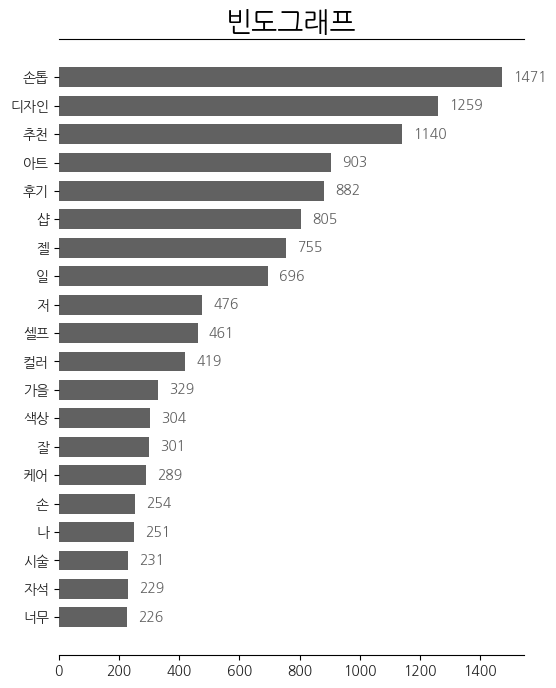

In [13]:
import matplotlib.pyplot as plt

# 색상
plt.figure(figsize=(6,8))
fcolor = '#212121'
gcolor = '#616161'

# 그래프 그리기
ax = plt.subplot()
hbars = ax.barh(most_n, most_v, height=0.7, color=gcolor)
ax.set_title('빈도그래프', fontsize=20)

# 눈금 라벨설정
ax.tick_params(axis='both', labelsize=10, labelcolor=fcolor)

# 테두리 삭제
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# 그래프에 값 라벨 표현
ax.bar_label(hbars, fmt='%g', padding=8, color=gcolor, fontsize=10)
plt.show()

## TF-IDF 그리기
TF-IDF그래프 또한 빈도그래프와 동일하게 sklearn의 `TfidfVectorizer`를 이용하여 그려줍니다.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tvec = TfidfVectorizer(max_df=0.9, min_df=20)
X = tvec.fit_transform(df['clean'])
names = tvec.get_feature_names_out() # 토큰 목록을 배열로 가져옴
x = X.toarray()
xsum = np.mean(x, axis=0) # 2차원 배열의 벡터를 세로(0번축)으로 합침

most_n = []
most_v = []
for ind in np.argsort(xsum)[-20:]: # argsort() 값이 작은 순으로 인덱스가 정렬
    most_n.append(names[ind]) # 토큰과 개수를 순서별로 저장
    most_v.append(xsum[ind])
most_n.reverse()
most_v.reverse()
print(most_n)
print(most_v)

['손톱', '아트', '디자인', '추천', '후기', '셀프', '컬러', '가을', '케어', '색상', '자석', '너무', '시술', '관리', '맞춤', '이달', '방문', '웨딩', '여름', '다양']
[np.float64(0.10818148138452327), np.float64(0.0979561853285006), np.float64(0.09366463758553138), np.float64(0.08951218616818338), np.float64(0.08025729230949559), np.float64(0.06986778862946388), np.float64(0.05672888801829956), np.float64(0.05435755682074194), np.float64(0.04546799765984815), np.float64(0.04365751420668289), np.float64(0.041345808361304255), np.float64(0.03996098098550463), np.float64(0.039154086108603534), np.float64(0.03774108920304206), np.float64(0.03446507243634992), np.float64(0.03196773481936961), np.float64(0.03171038695411509), np.float64(0.0301083355278786), np.float64(0.030029159902726133), np.float64(0.029737275771527398)]


## 워드 클라우드

워드클라우드(word cloud)는 텍스트 뭉치 내의 단어의 빈도수를 계산하여 빈도에 따라다 단어의 크기를 달리 표현하는 시각화 방법입니다.   
텍스트 데이터의 주요 키워드를 한눈에 파악할 수 있어 자주 사용되는 시각화 방법중 하나입니다.

In [15]:
from wordcloud import WordCloud
import numpy as np

# WordCloud 모델 생성

wc = WordCloud(font_path='basic_data/NanumGothic.ttf',  # 폰트입력
               background_color="white",  # 배경색
               collocations=False,  # 두개의 단어를 붙이지 않음
               width=800,  # 넓이
               height=800,  # 높이
               scale=1)                  # 스케일


wc.generate(' '.join(df['clean'])) # 모델에 텍스트 뭉치 입력

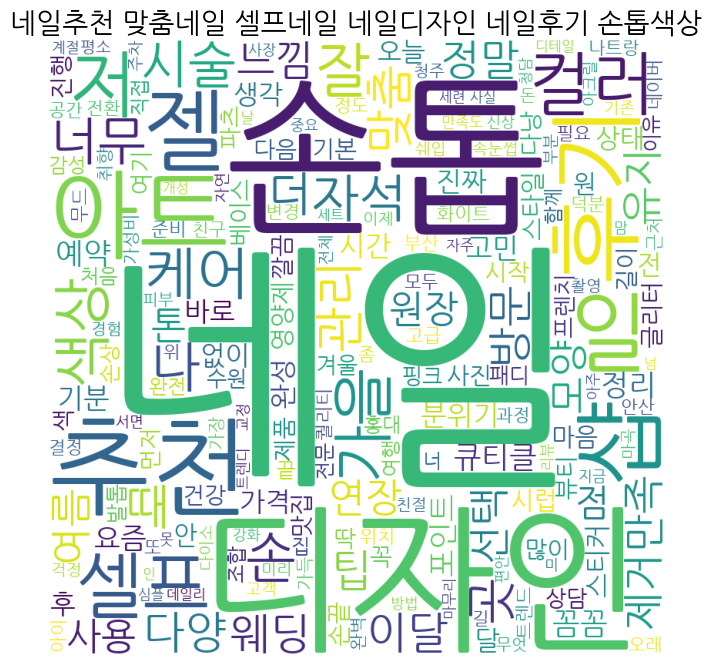

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

ax = plt.subplot()
ax.imshow(wc) # 이미지를 표에 입력
ax.set_title(keyword, fontsize=20)

for i in 'top bottom right left'.split():
    ax.spines[i].set_visible(False)

ax.tick_params(left=False, right=False, labelleft=False,
               labelbottom=False, bottom=False)
plt.show()

In [17]:
# LDA 토픽 모델링 생성

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(max_df=0.9, min_df=5 )
tf = cvec.fit_transform(df['clean']) # 벡터화
model = LatentDirichletAllocation(n_components=4, # 토픽개수
                                  max_iter=10, # 반복 횟수
                                  learning_method = 'online', # 미니배치
                                  random_state=0,  # 난수 설정
                                 )

model.fit(tf)

model.components_

array([[ 1.90405711,  3.27363933,  2.81423676, ...,  9.0004367 ,
         0.27424338,  6.57734558],
       [ 1.84805442,  0.4741044 ,  0.2514221 , ...,  0.25730968,
         0.25928628,  0.5620878 ],
       [ 2.16475683, 72.25729767,  0.31767081, ...,  0.26340347,
         9.6886844 ,  0.28743126],
       [ 2.34449931, 19.51926086,  9.35403369, ...,  1.14876717,
         0.25999602,  5.75778722]], shape=(4, 729))

In [18]:
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

# lda 모델, 벡터, 벡터모델을 인자로 하여 시각화 자료 생성
pl = pyLDAvis.lda_model.prepare(model, tf, cvec)

# 반응형 html로 저장
pyLDAvis.save_html(pl, 'lda_cvec.html')
# 노트북에 출력
pyLDAvis.display(pl)

In [19]:
# 단어쌍 빈도 구하기
count = {}
for line in df['clean']:
    words = list(set(line.split()))
    for i, a in enumerate(words):
        for b in words[i + 1:]:   # 앞뒤 단어를 사전으로 묶어 카운트 (앞뒤가 달라도 동일하게)
            if a > b:
                count[b, a] = count.get((b, a), 0) + 1
            else:
                count[a, b] = count.get((a, b), 0) + 1

net_list = [(w[0], w[1], count[w]) for w in count]
net_df = pd.DataFrame(net_list, columns=['w1', 'w2', 'f']) # 데이터프레임으로 변환
net_df = net_df.sort_values(by=['f'], ascending=False) # 빈도수로 정렬
net_df = net_df[net_df['f'] > 10] # 너무 적은 빈도는 제외
net_df

,w1,w2,f
120,네일,디자인,779
73,네일,손톱,779
352,네일,추천,722
54,디자인,손톱,659
117,디자인,추천,615
...,...,...,...
28379,기존,케어,11
0,넘,젤,11
4690,안산,추천,11
4735,검색,샵,11


In [20]:
## 연결 중심성 결과 값으로 그래프 재생성
import networkx as nx

G_cen = nx.Graph()

## 1차 그래프 그리기
    # 두단어를 두개의 노드로 그리기
    # 두단어를 엣지로 연결하고 엣지에 가중치 할당
for net in net_df.iloc:
    G_cen.add_edge(net['w1'], net['w2'], weight=int(net['f']))

# 1차 그래프를 활용해 중심성 알고리즘으로 노드의 크기 연산
centrality = nx.degree_centrality(G_cen) # 연결중심성

# centrality = nx.pagerank(G_cen) # 페이지링크

print(centrality)

{'네일': 0.9936575052854123, '디자인': 0.839323467230444, '손톱': 0.8773784355179705, '추천': 0.7949260042283298, '후기': 0.6828752642706132, '아트': 0.5200845665961945, '샵': 0.5158562367864694, '일': 0.5031712473572939, '저': 0.3572938689217759, '젤': 0.3572938689217759, '색상': 0.2748414376321353, '컬러': 0.2959830866807611, '잘': 0.24312896405919662, '셀프': 0.2367864693446089, '손': 0.23255813953488372, '케어': 0.20718816067653278, '너무': 0.18181818181818182, '가을': 0.19027484143763215, '시술': 0.18816067653276958, '나': 0.16067653276955604, '때': 0.1649048625792812, '곳': 0.1649048625792812, '다양': 0.15856236786469347, '더': 0.16279069767441862, '관리': 0.16913319238900634, '맞춤': 0.14587737843551798, '방문': 0.15010570824524314, '정말': 0.13742071881606766, '느낌': 0.12473572938689219, '선택': 0.11416490486257928, '만족': 0.12473572938689219, '이달': 0.11839323467230445, '자석': 0.08879492600422834, '유지': 0.10993657505285413, '제거': 0.12050739957716702, '모양': 0.10570824524312897, '꼼꼼': 0.10570824524312897, '톤': 0.10147991543340382,

In [21]:
## 2차 그래프 그리기
G = nx.Graph()
nsize = 10000 # 노드 크기
w_size = 30 # 표현될 상위 키위드 개수

# 중심성 알고리즘을 통해 연산한 단어의 중심값을 노드의 크기로 설정
node_size = []
for node in list(centrality)[:w_size]:
    G.add_node(node)
    node_size.append(centrality[node]*nsize)

# 엣지 가중치는 빈도수로 동일하게 설정
for net in net_df.iloc:
    if net['w1'] in G.nodes and net['w2'] in G.nodes:
        G.add_weighted_edges_from([(net['w1'], net['w2'], int(net['f']))])

print(node_size)

[9936.575052854123, 8393.234672304441, 8773.784355179705, 7949.260042283298, 6828.752642706132, 5200.845665961945, 5158.562367864694, 5031.712473572939, 3572.938689217759, 3572.938689217759, 2748.4143763213533, 2959.830866807611, 2431.2896405919664, 2367.864693446089, 2325.5813953488373, 2071.881606765328, 1818.1818181818182, 1902.7484143763215, 1881.6067653276957, 1606.7653276955605, 1649.048625792812, 1649.048625792812, 1585.6236786469346, 1627.906976744186, 1691.3319238900635, 1458.77378435518, 1501.0570824524314, 1374.2071881606767, 1247.357293868922, 1141.6490486257928]


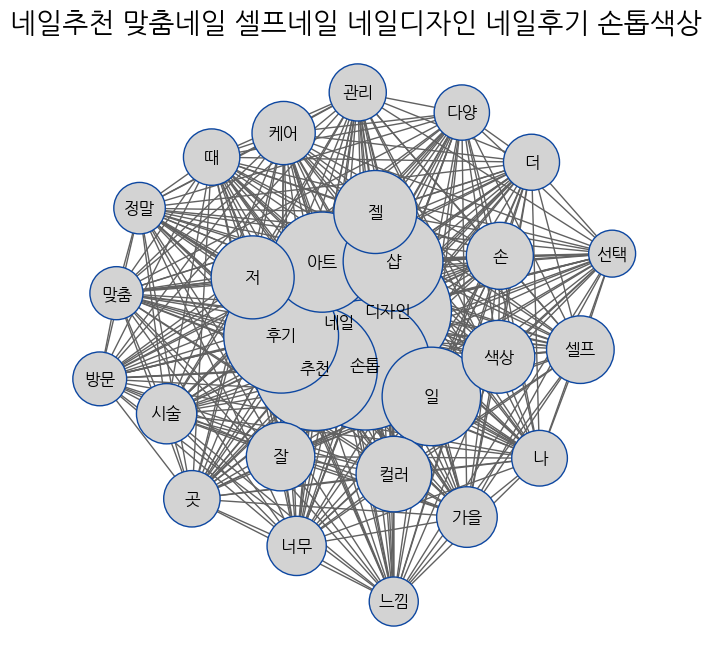

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
gcolor = '#616161'
ax = plt.subplot()

k = 0.4 # 작을수록 중앙 밀집
pos = nx.spring_layout(G, k=k)
nx.draw_networkx(G, pos,
                 ax = ax, # Axes
                 node_size=node_size, # 노드 크기
                 with_labels=True, # 글자 표현
                 edge_color=gcolor, # 엣지(연결선) 컬러
                 edgecolors='#0d47a1', # 노드의 테두리
                 node_color='lightgray', # 노드 컬러
                 font_weight='regular', # 폰트설정
                 font_family= 'NanumGothic')

for i in 'top bottom right left'.split():
    ax.spines[i].set_visible(False)

ax.tick_params(left=False, right=False, labelleft=False,
               labelbottom=False, bottom=False)
ax.set_title(keyword, fontsize=20)
plt.show()